#**Protein-protein complex structure prediction**
This notebook provides a general protein-protein complex structure prediction service utilizing RoseTTAFold2 and MiniWorld. It also offers specialized epitope-guided prediction for antigen-antibody complexes.


#### **Tips and Instructions**
- click the little ▶ play icon to the left of each cell to execute it.
- use ":" to specify multimeric inputs (e.g. sequence="AAA:BBB" for a two chain complex)
- Refer to the detailed instructions provided in each cell for guidance.


In [ ]:
%%time
#@title ##**Setup the system** (1~2m)##
#@markdown ####**Choose model parameters for prediction.**##
#@markdown - **RF2_apr23**: Use this model for general protein-protein complex structure prediction
#@markdown - **RF2_abag**: Use this model for epitope-guided **antibody-antigen** complex structure prediction

params = "RF2_abag" # @param ["RF2_apr23","RF2_abag"]

import os, time, sys
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

if params == "RF2_apr23" and not os.path.isfile(f"{params}.tgz"):
  # send param download into background
  print ("Download model weights")
  os.system("(apt-get install aria2; aria2c -q -x 16 https://files.ipd.uw.edu/dimaio/RF2_apr23.tgz) &")

if params == "RF2_abag" and not os.path.isfile(f"{params}.tgz"):
  # send param download into background
  print ("Download model weights")
  os.system("pip install gdown; gdown --id 18ZNdC9hHEGdSpJYfWKaAeqEMd9P3vTzl")


if not os.path.isdir("iitp-RF2"):
  print("Install RoseTTAFold2 & MiniWorld packages")
  os.system("git clone https://github.com/SNU-CSSB/iitp-RF2.git")
  # add codes to overwrite embedding module.
  os.system("pip install py3Dmol")

  # 17Mar2024: adding --no-dependencies to avoid installing nvidia-cuda-* dependencies
  os.system("pip install --no-dependencies dgl==2.0.0 -f https://data.dgl.ai/wheels/cu121/repo.html")
  os.system("pip install --no-dependencies e3nn==0.3.3 opt_einsum_fx")
  os.system("cd iitp-RF2/SE3Transformer; pip install .")

  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")

  #os.system("pip install dgl -f https://data.dgl.ai/wheels/cu121/repo.html")
  #os.system("cd RoseTTAFold2/SE3Transformer; pip -q install --no-cache-dir -r requirements.txt; pip -q install .")
  #os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/beta/colabfold/mmseqs/api.py")

  # install hhsuite
  print("Install hhsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

if not os.path.isfile(f"{params}.pt"):
  time.sleep(5)

if os.path.isfile(f"{params}.tgz.aria2"):
  print("Still downloading model weights")
  while os.path.isfile(f"{params}.tgz.aria2"):
    time.sleep(5)


if not os.path.isfile(f"{params}.pt"):
  os.system(f"tar -zxvf {params}.tgz")
  if params == "RF2_apr23":
    os.system(f"mv weights/{params}.pt .")

if not "IMPORTED" in dir():
  if 'iitp-RF2/network' not in sys.path:
    os.environ["DGLBACKEND"] = "pytorch"
    sys.path.append('iitp-RF2/network')
  if "hhsuite" not in os.environ['PATH']:
    os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

  import matplotlib.pyplot as plt
  from google.colab import files
  import numpy as np
  from parsers import parse_a3m
  #from api import run_mmseqs2
  from colabfold_utils import run_mmseqs2
  import py3Dmol
  import torch
  from string import ascii_uppercase, ascii_lowercase
  import hashlib, re, os
  import random

  def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
  alphabet_list = list(ascii_uppercase+ascii_lowercase)
  from collections import OrderedDict, Counter

  IMPORTED = True

if not "pred" in dir() or params_sele != params:
  from predict import Predictor
  print("Compile the network")

  if (torch.cuda.is_available()):
    pred = Predictor(f"{params}.pt", torch.device("cuda:0"))
  else:
    print ("WARNING: using CPU")
    pred = Predictor(f"{params}.pt", torch.device("cpu"))
  params_sele = params

def get_unique_sequences(seq_list):
    unique_seqs = list(OrderedDict.fromkeys(seq_list))
    return unique_seqs

def run_mmseqs2_wrapper(*args, **kwargs):
  kwargs['user_agent'] = "colabfold/rosettafold2"
  return run_mmseqs2(*args, **kwargs)

def get_msa(seq, jobname, cov=50, id=90, max_msa=2048,
            mode="unpaired_paired"):

  assert mode in ["unpaired","paired","unpaired_paired"]
  seqs = [seq] if isinstance(seq,str) else seq

  # collapse homooligomeric sequences
  counts = Counter(seqs)
  u_seqs = list(counts.keys())
  u_nums = list(counts.values())

  # expand homooligomeric sequences
  first_seq = "/".join(sum([[x]*n for x,n in zip(u_seqs,u_nums)],[]))
  msa = [first_seq]

  path = os.path.join(jobname,"msa")
  os.makedirs(path, exist_ok=True)
  if mode in ["paired","unpaired_paired"] and len(u_seqs) > 1:
    print("getting paired MSA")
    out_paired = run_mmseqs2_wrapper(u_seqs, f"{path}/", use_pairing=True)
    headers, sequences = [],[]
    for a3m_lines in out_paired:
      n = -1
      for line in a3m_lines.split("\n"):
        if len(line) > 0:
          if line.startswith(">"):
            n += 1
            if len(headers) < (n + 1):
              headers.append([])
              sequences.append([])
            headers[n].append(line)
          else:
            sequences[n].append(line)
    # filter MSA
    with open(f"{path}/paired_in.a3m","w") as handle:
      for n,sequence in enumerate(sequences):
        handle.write(f">n{n}\n{''.join(sequence)}\n")
    os.system(f"hhfilter -i {path}/paired_in.a3m -id {id} -cov {cov} -o {path}/paired_out.a3m")
    with open(f"{path}/paired_out.a3m","r") as handle:
      for line in handle:
        if line.startswith(">"):
          n = int(line[2:])
          xs = sequences[n]
          # expand homooligomeric sequences
          xs = ['/'.join([x]*num) for x,num in zip(xs,u_nums)]
          msa.append('/'.join(xs))

  if len(msa) < max_msa and (mode in ["unpaired","unpaired_paired"] or len(u_seqs) == 1):
    print("getting unpaired MSA")
    out = run_mmseqs2_wrapper(u_seqs,f"{path}/")
    Ls = [len(seq) for seq in u_seqs]
    sub_idx = []
    sub_msa = []
    sub_msa_num = 0
    for n,a3m_lines in enumerate(out):
      sub_msa.append([])
      with open(f"{path}/in_{n}.a3m","w") as handle:
        handle.write(a3m_lines)
      # filter
      os.system(f"hhfilter -i {path}/in_{n}.a3m -id {id} -cov {cov} -o {path}/out_{n}.a3m")
      with open(f"{path}/out_{n}.a3m","r") as handle:
        for line in handle:
          if not line.startswith(">"):
            xs = ['-'*l for l in Ls]
            xs[n] = line.rstrip()
            # expand homooligomeric sequences
            xs = ['/'.join([x]*num) for x,num in zip(xs,u_nums)]
            sub_msa[-1].append('/'.join(xs))
            sub_msa_num += 1
      sub_idx.append(list(range(len(sub_msa[-1]))))

    while len(msa) < max_msa and sub_msa_num > 0:
      for n in range(len(sub_idx)):
        if len(sub_idx[n]) > 0:
          msa.append(sub_msa[n][sub_idx[n].pop(0)])
          sub_msa_num -= 1
        if len(msa) == max_msa:
          break

  with open(f"{jobname}/msa.a3m","w") as handle:
    for n,sequence in enumerate(msa):
      handle.write(f">n{n}\n{sequence}\n")


Download model weights
Install RoseTTAFold2 & MiniWorld packages
Install hhsuite
Compile the network
CPU times: user 14.2 s, sys: 1.88 s, total: 16 s
Wall time: 1min 55s


In [ ]:
#@title ##**Input protein sequences**

#@markdown ####**Job name for the prediction run**
#@markdown - Provide a unique name for your prediction job. This name will help you identify and organize your results. Use a descriptive label, such as `ProteinA_ProteinB_Prediction` or `Antibody_Antigen_Run1`, for easy reference.
jobname = "EGFR_pantitumumab" #@param {type:"string"}

#@markdown ####**Sequence input**
# @markdown - Use `:` to indicate **inter-protein chain breaks** when modeling complexes. This supports both **homo-oligomers** and **hetero-oligomers**.
# @markdown
# @markdown    *Example* : `sequence="AAA:BBB"` for a two-chain complex.
# @markdown - For **antibody-antigen complexes**, provide the sequences in the following order:
# @markdown   1. Antibody heavy chain
# @markdown   2. Antibody light chain
# @markdown   3. Antigen chain(s)

sequence = "QVQLQESGPGLVKPSETLSLTCTVSGGSVSSGDYYWTWIRQSPGKGLEWIGHIYYSGNTNYNPSLKSRLTISIDTSKTQFSLKLSSVTAADTAIYYCVRDRVTGAFDIWGQGTMVTVSS:DIQMTQSPSSLSASVGDRVTITCQASQDISNYLNWYQQKPGKAPKLLIYDASNLETGVPSRFSGSGSGTDFTFTISSLQPEDIATYFCQHFDHLPLAFGGGTKVEIK:LEEKKVCNGIGIGEFKDSLSIDATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLDITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSHHHHHH" #@param {type:"string"}

msa_method = "mmseqs2"
collapse_identical = True

In [ ]:
#@title ##**Additional inputs for antibody-antigen complex structure prediction (only for RF2_abag)**
from google.colab import files

# @markdown #### **Individual Structural Models for Antibody and Antigen**
# @markdown - File upload will be activated when you run this cell.

# ab_pdb 업로드
print("Please upload the PDB file for antibody structure:")
ab_pdb = files.upload()
ab_pdb = os.path.abspath(list(ab_pdb.keys())[0])

# ag_pdb 업로드
print("\nPlease upload the PDB file for antigen structure:")
ag_pdb = files.upload()
ag_pdb = os.path.abspath(list(ag_pdb.keys())[0])


# 업로드된 파일 확인
print("\nUploaded ab_pdb file:", ab_pdb)
print("Uploaded ag_pdb file:", ag_pdb)

#@markdown #### **Epitope Residue Information (on Antigen)**
#@markdown - Specify the epitope residues in the format `A123,A152,A178`,
#@markdown   where `A` represents the chain identifier, and the number represents the residue number in the provided antigen PDB file.
#@markdown - Ensure the chain and residue numbers match the antigen PDB structure you uploaded.
#@markdown - Accurate epitope information is crucial for precise antibody-antigen complex predictions.
epitope_residue = "A132" #@param {type:"string"}
epitope_residue = epitope_residue.split(",")

Please upload the PDB file for antibody structure:


Saving ab_block.pdb to ab_block.pdb

Please upload the PDB file for antigen structure:


Saving ag_block.pdb to ag_block.pdb

Uploaded ab_pdb file: /content/ab_block.pdb
Uploaded ag_pdb file: /content/ag_block.pdb


In [ ]:
#@title ##**Run predictions**

# @markdown #### **Hidden Parameters**
# @markdown - This cell contains hidden parameters that you can modify for advanced customization.
# @markdown - Click "Show Code" to view and adjust parameters such as symmetry options, sequence pairing modes, model recycling settings, and stochasticity controls.
# @markdown - Modify these settings before running the cell by clicking the ▶ **play** icon.

# hidden parameters you may want to change
# Symmetry options for homo-oligomer complex structure prediction
sym = "X" #please select among ["X","C", "D", "T", "I", "O"]
order = 1 #number of identical copies. e.g. C2 symmetry ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] {type:"raw"}
msa_concat_mode = "diag" #Please select among ["diag", "repeat", "default"]

# Sequence pairing modes.
if "abag" in params:
  pair_mode = "unpaired" # You MUST use "unpaired" model for antibody-antigen complex sturcture prediction
else:
  pair_mode = "unpaired_paired" #choose one from ["unpaired_paired","paired","unpaired"]

# Recycling options. More recycles may improve the model quality, but it will become slower.
num_recycles = 10 # Integer > 0

# If you want to introduce some randomness, please modify below.
use_mlm = False
use_dropout = False
max_msa = 256 #[16, 32, 64, 128, 256, 512] {type:"raw"}
random_seed = 0 # {type:"integer"}
num_models = 1 # ["1", "5", "10", "15", "20", "25"] {type:"raw"}
max_extra_msa = max_msa * 8


# Below is to run structure prediction. Please don't touch.
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)

if sym in ["X","C"]:
  copies = order
elif sym in ["D"]:
  copies = order * 2
else:
  copies = {"T":12,"O":24,"I":60}[sym]
  order = ""
symm = sym + str(order)

sequences = sequence.replace(":","/").split("/")
if collapse_identical:
  u_sequences = get_unique_sequences(sequences)
else:
  u_sequences = sequences
sequences = sum([u_sequences] * copies,[])
lengths = [len(s) for s in sequences]

subcrop = -1
topk = 1536

sequence = "/".join(sequences)
jobname = jobname+"_"+symm+"_"+get_hash(sequence)[:5]

print(f"jobname: {jobname}")
print(f"lengths: {lengths}")

os.makedirs(jobname, exist_ok=True)
if msa_method == "mmseqs2":
  get_msa(u_sequences, jobname, mode=pair_mode, max_msa=max_extra_msa)

elif msa_method == "custom_a3m":
  print("upload custom a3m")
  msa_dict = files.upload()
  lines = msa_dict[list(msa_dict.keys())[0]].decode().splitlines()
  a3m_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      a3m_lines.append(line)

  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write("\n".join(a3m_lines))

best_plddt = None
best_seed = None
for seed in range(random_seed,random_seed+num_models):
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)
  npz = f"{jobname}/rf2_seed{seed}_00.npz"
  if "abag" in params_sele:
    print ("Input epitopes", epitope_residue)
    pred.predict_abag(msa=f"{jobname}/msa.a3m",
              ab_pdb=ab_pdb, ag_pdb=ag_pdb,
              epi_s=epitope_residue,
              out_prefix=f"{jobname}/rf2_seed{seed}",
              n_recycles=num_recycles,
              msa_mask=0.15 if use_mlm else 0.0,
              msa_concat_mode=msa_concat_mode,
              nseqs=max_msa,
              nseqs_full=max_extra_msa,
              subcrop=subcrop,
              topk=topk,
              is_training=use_dropout)
  else:
    pred.predict(inputs=[f"{jobname}/msa.a3m"],
                out_prefix=f"{jobname}/rf2_seed{seed}",
                symm=symm,
                ffdb=None, #TODO (templates),
                n_recycles=num_recycles,
                msa_mask=0.15 if use_mlm else 0.0,
                msa_concat_mode=msa_concat_mode,
                nseqs=max_msa,
                nseqs_full=max_extra_msa,
                subcrop=subcrop,
                topk=topk,
                is_training=use_dropout)
  plddt = np.load(npz)["lddt"].mean()
  if best_plddt is None or plddt > best_plddt:
    best_plddt = plddt
    best_seed = seed

jobname: EGFR_pantitumumab_X1_902ca_X1_902ca_X1_902ca
lengths: [119, 107, 201]
getting unpaired MSA


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:02 remaining: 00:00]


Input epitopes ['A132']
N=2048 L=427
recycle 0 plddt 0.804 pae 12.445 rmsd 16.619
recycle 1 plddt 0.847 pae 8.391 rmsd 1.914
Updated epitope: 78,101,102,103,104,105,106,109,111,112,130,131,132,133,134,135,154,155,157,158,159,160,161,162
recycle 2 plddt 0.859 pae 6.273 rmsd 0.563
Updated epitope: 78,101,102,103,104,105,106,109,111,112,130,131,132,133,134,135,137,154,155,157,158,159,160,161,162
recycle 3 plddt 0.868 pae 5.281 rmsd 0.982
Updated epitope: 76,78,102,103,104,105,106,109,111,112,130,132,133,134,135,137,155,157,158,159,160,161,162
recycle 4 plddt 0.866 pae 5.621 rmsd 0.288
Updated epitope: 76,78,102,103,104,105,106,109,111,112,130,131,132,133,134,135,137,155,157,158,159,160,161,162
recycle 5 plddt 0.870 pae 5.184 rmsd 0.210
Updated epitope: 76,78,102,103,104,105,106,109,111,112,130,131,132,133,134,135,137,155,157,158,159,160,161,162
recycle 6 plddt 0.863 pae 5.562 rmsd 0.248
Updated epitope: 76,78,102,103,104,105,106,109,111,112,130,132,133,134,135,137,155,157,158,159,160,161,

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

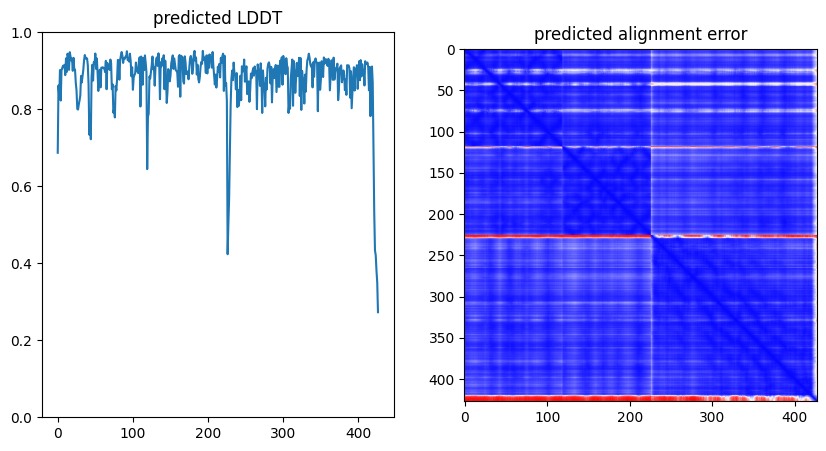

In [ ]:
#@title ##**Display 3D structure** {run: "auto"}
os.system("pip install py3Dmol")

color = "plddt" #@param ["plddt","chain","rainbow"]
import py3Dmol
import matplotlib
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]
pymol_cmap = matplotlib.colors.ListedColormap(pymol_color_list)

def plot_pdb(pdb, color="plddt"):
  hbondCutoff = 4.0
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  pdb_str = open(pdb,'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,c in zip(range(len(lengths)),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':c}})
  else:
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  view.zoomTo()
  view.show()

plot_pdb(f"{jobname}/rf2_seed{best_seed}_00_pred.pdb", color=color)
output = dict(np.load(f"{jobname}/rf2_seed{best_seed}_00.npz"))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("predicted LDDT")
plt.plot(output["lddt"])
plt.ylim(0,1.0)
plt.subplot(1,2,2)
plt.title("predicted alignment error")
plt.imshow(output["pae"],vmin=0,vmax=30,cmap="bwr")
plt.show()

In [ ]:
#@title ##**Evaluate prediction based on DockQ**

os.system("pip install DockQ")
pdb_code = "5sx4" #@param {type:"string"}
#@markdown - PDB code for the ground truth structure deposited in PDB database.

#@markdown #### **Metrics used for evaluation**
#@markdown - **`DockQ`**: Docking quality score ranging from 0 to 1 (higher is better).
#@markdown - **`iRMSD`**: Interface Root Mean Square Deviation (Å) for interface residues.
#@markdown - **`LRMSD`**: Ligand Root Mean Square Deviation (Å) for the entire ligand.
#@markdown - **`fnat`**: Fraction of native contacts (range 0-1, higher indicates more correct contacts).

if not os.path.isfile(f"{pdb_code}.pdb1"):
  os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz")
  os.system(f"gunzip {pdb_code}.pdb1.gz")
nat_fn = f"{pdb_code}.pdb1"

pdb_fn = f"{jobname}/rf2_seed{best_seed}_00_pred.pdb"
lines = os.popen(f"DockQ {pdb_fn} {nat_fn} --short --allowed_mismatches 10").readlines()[-1]

import pandas as pd

# Parsing the string into a dictionary
data_list = lines.split()[:8]
metrics = data_list[0::2]  # Extract metric names (even indices)
values = data_list[1::2]   # Extract corresponding values (odd indices)

# Convert values to numeric types where possible
values = [float(value) if '.' in value else int(value) for value in values]

# Create a DataFrame
data = {"Metric": metrics, "Value": values}
df = pd.DataFrame(data)

# Display the table in Google Colab
df.style.set_properties(**{'text-align': 'center'})


,Metric,Value
0,DockQ,0.387000
1,iRMSD,3.357000
2,LRMSD,11.013000
3,fnat,0.622000


In [ ]:
#@title ##**Download prediction**

#@markdown Once this cell has been executed, a zip-archive with
#@markdown the obtained prediction will be automatically downloaded
#@markdown to your computer.

# add settings file
settings_path = f"{jobname}/settings.txt"
with open(settings_path, "w") as text_file:
  text_file.write(f"method=RoseTTAFold2\n")
  text_file.write(f"params={params}\n")
  text_file.write(f"sequence={sequence}\n")
  text_file.write(f"sym={sym}\n")
  text_file.write(f"order={order}\n")
  text_file.write(f"msa_concat_mode={msa_concat_mode}\n")
  text_file.write(f"collapse_identical={collapse_identical}")
  text_file.write(f"random_seed={random_seed}\n")
  text_file.write(f"msa_method={msa_method}\n")
  text_file.write(f"num_recycles={num_recycles}\n")
  text_file.write(f"use_mlm={use_mlm}\n")
  text_file.write(f"use_dropout={use_dropout}\n")
  text_file.write(f"num_models={num_models}\n")

# --- Download the predictions ---
os.system(f"zip -r {jobname}.zip {jobname}")
files.download(f'{jobname}.zip')